<span style="font-size:3.5em;"> Netflix Recommendation  </span>

# Import Data

## Import Library 

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Draws graphes 
import seaborn as sns #Draws intuitive graphs 
import warnings #Removes warnings
from glob import glob
import os
import sys
import pandas_profiling
from surprise import Dataset
from surprise.model_selection import train_test_split
from pyspark.sql import SparkSession
from surprise import Reader
from surprise.prediction_algorithms import SVD
from surprise.model_selection import cross_validate
from surprise import Prediction
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic,KNNBaseline
from surprise.similarities import pearson_baseline

warnings.filterwarnings("ignore")
%matplotlib inline

## Data

In [109]:
cd \Users\laure\Flatiron\Phase4-project

C:\Users\laure\Flatiron\Phase4-project


In [110]:
csv_files = glob('./*.csv')
csv_files

['.\\links.csv', '.\\movies.csv', '.\\ratings.csv', '.\\tags.csv']

In [111]:
df_links = pd.read_csv('.\\links.csv')
df_movies = pd.read_csv('.\\movies.csv')
df_ratings = pd.read_csv('.\\ratings.csv')
df_tags = pd.read_csv('.\\tags.csv')


In [112]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [113]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


- Need to pull out year from title
- Need to separate genres

In [114]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [115]:
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [116]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [117]:
df_new = pd.merge(df_ratings, df_movies, how= 'outer', on= 'movieId')
df_new.head()

,userId,movieId,rating,timestamp,title,genres
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [118]:
df_new.drop(columns = ['timestamp', 'genres'], inplace = True)
df_new

,userId,movieId,rating,title
0,1.0,1,4.0,Toy Story (1995)
1,5.0,1,4.0,Toy Story (1995)
2,7.0,1,4.5,Toy Story (1995)
3,15.0,1,2.5,Toy Story (1995)
4,17.0,1,4.5,Toy Story (1995)
...,...,...,...,...
100849,NaN,30892,NaN,In the Realms of the Unreal (2004)
100850,NaN,32160,NaN,Twentieth Century (1934)
100851,NaN,32371,NaN,Call Northside 777 (1948)
100852,NaN,34482,NaN,"Browning Version, The (1951)"


In [119]:
df_new.isnull().sum()


userId     18
movieId     0
rating     18
title       0
dtype: int64

In [120]:
df_new = df_new[df_new['userId'].notna()]

In [121]:
df_new.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

# Clean Data

In [122]:
### Dealing with Null Values 

In [123]:
df_links.info()
df_movies.info()
df_ratings.info()
df_tags.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  fl

The df_links dataframe connest the the different movie source ideas.  The other dataframes only use movieId because of this this dataframe has no value added.  Will not be using this data fram further. 

### Create New Column

In [125]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [126]:
df_movies['year'] = df_movies['title'].str[-6:]
df_movies['year'] = df_movies['year'].str.replace('(', '').str.replace(')','')
df_movies


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [127]:
df_movies[['year']].value_counts().sort_index(ascending=True)

year  
1902      1
1903      1
1908      1
1915      1
1916      4
         ..
nimals    1
nlight    1
terson    1
ylon 5    1
–2007     1
Length: 128, dtype: int64

In [128]:
df_movies1=df_movies.loc[(df_movies['year'] >= '0') & (df_movies['year'] <= '2020')]
df_movies1

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [129]:
df_movies1[['year']].value_counts().sort_index(ascending=True)

year 
1902       1
1903       1
1908       1
1915       1
1916       4
        ... 
2014       1
2015     274
2016     218
2017     147
2018      41
Length: 115, dtype: int64

In [130]:
df_movies1['year']=df_movies1['year'].astype(float)
df_movies1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9729 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9729 non-null   int64  
 1   title    9729 non-null   object 
 2   genres   9729 non-null   object 
 3   year     9729 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 380.0+ KB


# Data Exploration 

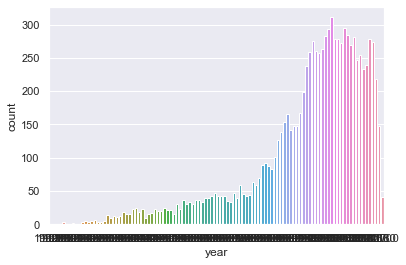

In [131]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="year", data=df_movies1)

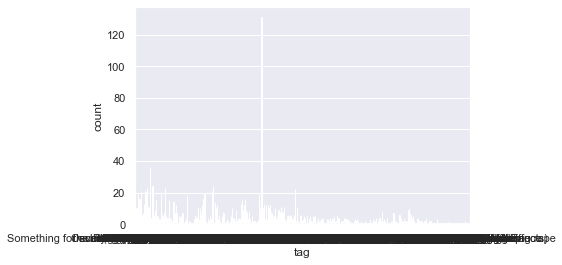

In [132]:

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="tag", data=df_tags)

# Modeling

In [133]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  float64
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.8+ MB


In [134]:
df_new.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [135]:
df_new['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [136]:
reader = Reader(rating_scale=(.5, 5))
data = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']], reader)
type(data)

surprise.dataset.DatasetAutoFolds

Grid search 

In [29]:
#data = Dataset.load_from_file(file_path, reader=reader)

## SVD

In [30]:
param_grid = {'n_factors': [25, 50, 100, 125, 150],
              'n_epochs': [5, 10], 
              'lr_all': [0.002, 0.005, .01],
              'reg_all': [.01, .02, 0.4, 0.6], 
              'verbose': [True],
              'random_state': [10]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing e

Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing e

Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing e

Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing e

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing e

Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing e

Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing e

In [137]:
svd = SVD(n_factors= 25, n_epochs= 10, lr_all= 0.01, reg_all= 0.02, verbose= True, random_state = 10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8781  0.8743  0.8740  0.8755  0.0019  
MAE (testset)     0.6768  0.6745  0.6718  0.6743  0.0020  
Fit time          2.65    2.56    2.55    2.59    0.05    
Test time         0.64    0.68    0.65    0.65    0.02    


{'test_rmse': array([0.87809693, 0.87427643, 0.87398706]),
 'test_mae': array([0.67678146, 0.67446535, 0.67177188]),
 'fit_time': (2.6488759517669678, 2.560546875, 2.547030210494995),
 'test_time': (0.6400728225708008, 0.6776025295257568, 0.646306037902832)}

## KNN Basic

In [32]:
param_grid = {'k': [25, 40, 60, 100],
              'min_k': [1, 5, 10, 25],  
              'verbose': [True],
              'random_state': [10]}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [138]:
knnbasic = KNNBasic(k= 25, min_k = 5, verbose= True, random_state = 10)
cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9511  0.9471  0.9567  0.9516  0.0039  
MAE (testset)     0.7267  0.7249  0.7380  0.7298  0.0058  
Fit time          0.33    0.36    0.35    0.35    0.01    
Test time         5.79    5.44    5.39    5.54    0.18    


{'test_rmse': array([0.95109778, 0.94710011, 0.95671628]),
 'test_mae': array([0.72667484, 0.72488787, 0.73795391]),
 'fit_time': (0.3332388401031494, 0.35935258865356445, 0.3509860038757324),
 'test_time': (5.787621021270752, 5.437287330627441, 5.39056921005249)}

## KNN Baseline

In [34]:
#sim_options = {'name': 'pearson_baseline', 'user_based': False}
param_grid = {'k': [25, 40, 60, 100],
              'min_k': [1, 5, 10, 25],
#              'sim_options': [sim_options],  
              'verbose': [True],
              'random_state': [10]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [139]:
knnbaseline = KNNBaseline(k= 40, min_k = 5, verbose= True, random_state = 10)
cross_validate(knnbaseline, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8722  0.8676  0.8741  0.8713  0.0028  
MAE (testset)     0.6683  0.6654  0.6722  0.6686  0.0028  
Fit time          0.60    0.62    0.62    0.61    0.01    
Test time         8.86    8.38    8.68    8.64    0.20    


{'test_rmse': array([0.87222669, 0.86756963, 0.87414762]),
 'test_mae': array([0.66826856, 0.66541529, 0.67216678]),
 'fit_time': (0.6013486385345459, 0.6158695220947266, 0.6197497844696045),
 'test_time': (8.8552987575531, 8.379266500473022, 8.678531408309937)}

## KNN with Means 

In [36]:
param_grid = {'k': [25, 40, 60, 100],
              'min_k': [1, 5, 10, 25], 
              'verbose': [True],
              'random_state': [10]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# best MAE score
print(gs.best_score['mae'])

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [140]:
knnwithmeans = KNNWithMeans(k= 60, min_k = 5, verbose= True, random_state = 10)
cross_validate(knnwithmeans, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9001  0.8897  0.9093  0.8997  0.0080  
MAE (testset)     0.6887  0.6822  0.6928  0.6879  0.0044  
Fit time          0.39    0.40    0.40    0.40    0.01    
Test time         7.39    7.67    7.29    7.45    0.16    


{'test_rmse': array([0.90008616, 0.88968597, 0.90928067]),
 'test_mae': array([0.68870805, 0.68218204, 0.69283263]),
 'fit_time': (0.3903036117553711, 0.4006228446960449, 0.4014267921447754),
 'test_time': (7.391425132751465, 7.667977333068848, 7.294941425323486)}

# Making predictions 

In [141]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5,\ 
                       press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId']
                                .values[0],'rating':int(rating)}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list  

In [155]:
user_rating = movie_rater(df_movies, 4, 'Comedy')


      movieId                         title  genres  year
1675     2255  Young Doctors in Love (1982)  Comedy  1982
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                 title  genres  year
1927     2555  Baby Geniuses (1999)  Comedy  1999
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId             title         genres  year
9042   141718  Deathgasm (2015)  Comedy|Horror  2015
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                title               genres  year
7526    84523  Kill! (Kiru) (1968)  Action|Comedy|Drama  1968
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3


In [156]:
#train set 

#predict set 


user_rating
remove user ID 


[{'userId': 1000, 'movieId': 2255, 'rating': 3},
 {'userId': 1000, 'movieId': 2555, 'rating': 3},
 {'userId': 1000, 'movieId': 141718, 'rating': 3},
 {'userId': 1000, 'movieId': 84523, 'rating': 3}]

In [70]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,df_movies,5)

In [69]:
# order the predictions from highest to lowest rated

ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
